# Deep Learning Project: corrosion detection on steel pipes

_Teacher: Emmanuelle Claeys_

_Student: Thomas Labreur (student ID: 21512408)_

_M2 SID University Toulouse III Paul Sabatier_

This notebook contains the main part of the deep learning project I performed in 2024. The aim is studying images representing pipes thickness and to identify areas with corrosion. For that, a convolutionnal neural network (CNN) will be trained on those images which have been cut into patches of 36x36 pixels.


In [29]:
# Generic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# Deep learning modules
from keras import Model
from keras.layers import Conv2D, Dense, Input, Flatten
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# My own modules 
from iou import IoU
from preprocessing import preprocess

## Retreive data

Here one can find out how our data look like and below the groundtruth, in other words, the corrosion areas we want to detect. As one can see, some data have outlier pixels with high negative values, and other have missing values.

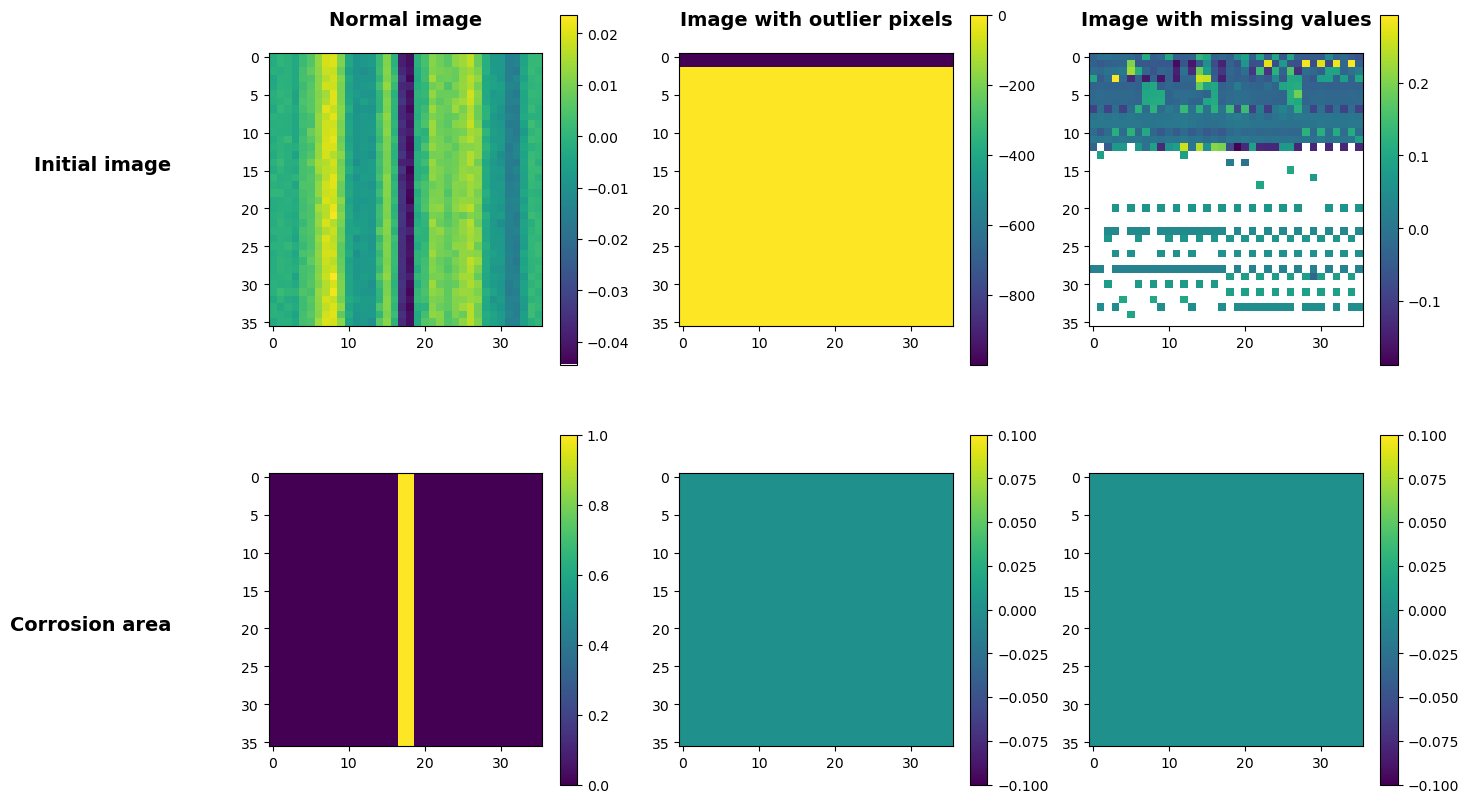

In [2]:
# Groundtruth
y_train = pd.read_csv("data/y_train.csv", index_col=0)

# Pick up some examples
outlier_example = "well_10_patch_0"
nan_example = "well_15_patch_202"
normal_example = "well_1_patch_0"

# Figure initialization
titles = ["Normal image", "Image with outlier pixels", "Image with missing values"]
fig, ax = plt.subplots(2,3, figsize=(15,10))
fig.text(0.06, 0.73 , 'Initial image', va='center', ha='right', fontsize=14, fontweight='bold')
fig.text(0.06, 0.27 , 'Corrosion area', va='center', ha='right', fontsize=14, fontweight='bold')


for i, name in enumerate([normal_example, outlier_example, nan_example]):
    
    # Load image and groundtruth
    x = np.load("data/x_train/" + name + ".npy")
    y = y_train.loc[name].values.reshape((36,36))
    
    # Plot image and groundtruth below
    ax[0,i].set_title(titles[i], fontsize=14, fontweight='bold', pad=20)
    im1 = ax[0,i].imshow(x)
    im2 = ax[1,i].imshow(y)
    plt.colorbar(im1, ax = ax[0,i])
    plt.colorbar(im2, ax = ax[1,i])


## Data pre-processing

As recommended on the context document, the pre-processing step is divided in three steps:

- The images with missing values will be removed (there's only two of them)
- The images containing outlier pixels will be removed. Outlier pixels are aberrant values which I considered as values with a z-score greater than 3 (a pixel z_score is computed with respect to the overall collection of images, not only the one to which the pixel belongs).
- The remaining images will be scaled using a robust scaler.

In [3]:
# Pre-process X
# The following function handles all the pre-processing and returns names of inlier patches and themselves after scaling.
inlier_names, X = preprocess("data/x_train", 3) # 3 is the limit z_score for outlier detection

# Only keep y values for inlier patches
y = y_train.loc[inlier_names]

340 files have been removed, 9334 still remain.


Here some examples of clean data.

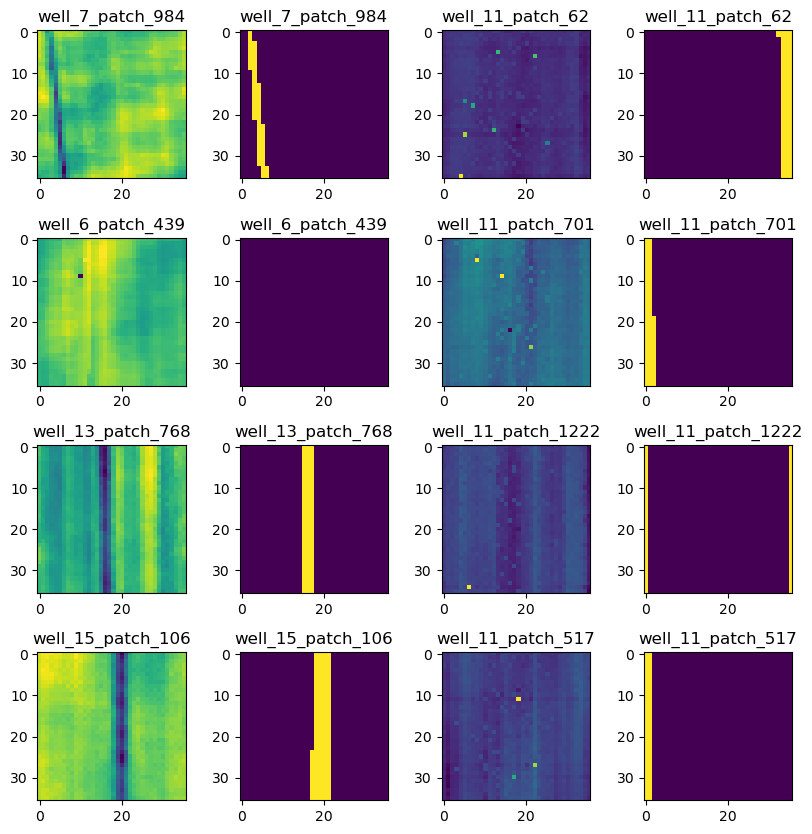

In [11]:
# Random examples
examples = random.sample(range(len(X)), 8)

plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=.4)
for i, ex in enumerate(examples):
    plt.subplot(4,4, 2*i+1)
    plt.imshow(X[ex])
    plt.title(inlier_names[ex])
    plt.subplot(4,4,2*i+2)
    plt.imshow(y.loc[inlier_names[ex]].values.reshape(36,36))
    plt.title(inlier_names[ex])


## Model

TODO
- rajouter les commentaires de cette section
- changer le nom X_test, y_test en X_val, y_val pour éviter la confusion avec les vrais X_test
- ajouter de la data augmentation
- mesurer l'IoU, si possible au cours du training
- éventuellement mettr eun callback pour garder le modèle le plus perfomant uniquement
- écrire le README

In [ ]:
# Train validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)

In [ ]:
# Model definition
inputs = Input(shape = (36,36,1))
x = Conv2D(8, (3,3), activation='relu')(inputs)
x = Conv2D(16, (3,3), activation='relu')(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
outputs = Dense(36*36, activation='sigmoid')(x)

# Model creation
model = Model(inputs, outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 36, 36, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 34, 34, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 30, 30, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     8,652,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1296)           │       130,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,882,036 (33.88 MB)

 Trainable params: 8,882,036 (33.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 415ms/step - loss: 0.3768 - val_loss: 0.1657
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 445ms/step - loss: 0.1444 - val_loss: 0.1034
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 432ms/step - loss: 0.0974 - val_loss: 0.0906
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 435ms/step - loss: 0.0828 - val_loss: 0.0839
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 421ms/step - loss: 0.0725 - val_loss: 0.0796
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 427ms/step - loss: 0.0649 - val_loss: 0.0801
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 418ms/step - loss: 0.0571 - val_loss: 0.0784
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 445ms/step - loss: 0.0496 - val_loss: 0.0828
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 444ms/step - loss: 0.0432 - val_loss: 0.0845
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 441ms/step - loss: 0.0370 - val_loss: 0.0840
Epoch 11/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 440ms/step - loss: 0.0317 - val_loss: 0.0935
Epoch 12/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 29

KeyError: 'val loss'

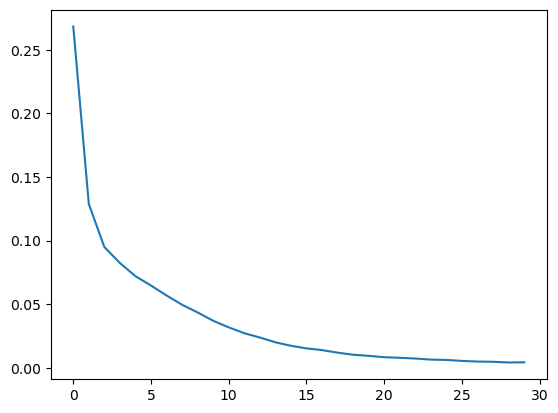

In [ ]:
# Parameters
batch_size = 128
epochs = 30
lr = 0.001

# Compile and training
model.compile(optimizer=Adam(learning_rate=lr),
              loss=BinaryCrossentropy)
model.fit(X_train, y_train, 
          batch_size = batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))

# Plot loss evolution through epochs
hist = model.history.history
plt.plot(hist['loss'], label='loss')
plt.plot(hist['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

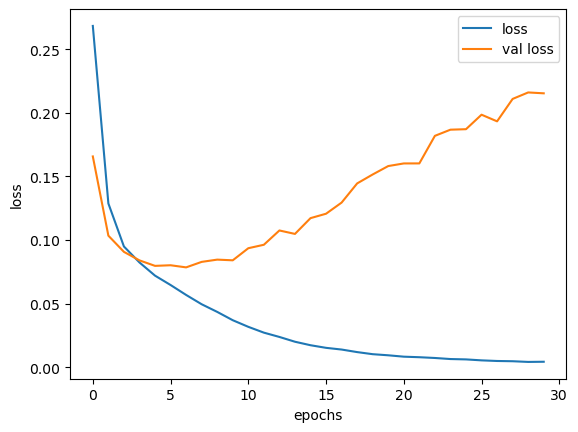

In [34]:
hist = model.history.history
plt.plot(hist['loss'], label='loss')
plt.plot(hist['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

In [35]:
pred = pd.DataFrame(model.predict(X_test), index = y_test.index)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


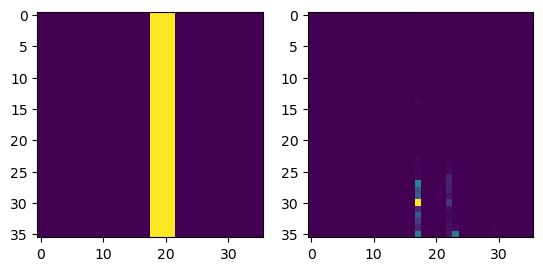

In [40]:
i=269
plt.subplot(1,2,1)
plt.imshow(y.iloc[i].values.reshape(36,36))

plt.subplot(1,2,2)
plt.imshow(pred.iloc[i].values.reshape(36,36))

In [22]:
X[i].shape

(36, 36, 1)